In [2]:
import pandas as pd
import numpy as np
import requests
import json
from tqdm import tqdm
from scipy import stats

In [ ]:
df = pd.read_excel('data/asap-aes/training_set_rel3.xlsx')


df_sample = df[df["essay_set"] == 8][0:1]

API_BASE_URL = "http://localhost:8000/api"

import time

def create_submission(essay, assignment_id):
    response = requests.post(f"{API_BASE_URL}/submissions/submit_text/", json={
        "content": essay,
        "assignment": assignment_id, 
        "student_name": "Anonymous"
    })
    if response.status_code != 201:
        print(f"Error creating submission: {response.status_code}")
        print(f"Response content: {response.text}")
        return None
    return response.json()
    
import time

def process_submissions(df_sample, assignment_id):
    system_grades = []
    submission_ids = []
    
    for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
        # Create submission
        submission = create_submission(row['essay'], assignment_id)
        if submission is None:
            continue
        
        # Print submission response for debugging
        print(f"Submission response: {submission}")
        
        # Check if 'id' is in the response, if not, use an alternative field or skip
        if 'id' in submission:
            submission_id = submission['id']
        else:
            print(f"Unable to find submission ID in response: {submission}")
            continue
        
        submission_ids.append(submission_id)
        
        # Wait for grading to complete and get results
        max_attempts = 20
        attempt = 0
        while attempt < max_attempts:
            result = get_grading_results(submission_id)
            print("RESULT", result)
            if result['status'] == 'graded':
                system_grades.append(result['overall_score'])
                break
            time.sleep(10)  # Wait for 10 seconds before checking again
            attempt += 1
        
        if attempt == max_attempts:
            print(f"Grading not completed for submission {submission_id} after {max_attempts} attempts")
            system_grades.append(None)
    
    return submission_ids, system_grades

def get_grading_results(submission_id):
    response = requests.get(f"{API_BASE_URL}/submissions/{submission_id}/")
    data = response.json()
    
    # Print the full response for debugging
    print(f"Full API response for submission {submission_id}:")
    print(json.dumps(data, indent=2))
    
    if data.get('status') == 'graded' and 'category_scores' in data:
        category_scores = data['category_scores']
        
        if category_scores and isinstance(category_scores[0], dict) and 'categories' in category_scores[0]:
            categories = category_scores[0]['categories']
            
            valid_scores = [cat['score'] for cat in categories if isinstance(cat.get('score'), (int, float))]
            
            if valid_scores:
                overall_score = sum(valid_scores) / len(valid_scores)
                return {
                    'status': 'graded',
                    'overall_score': overall_score / 6  # Assuming the max score is 6
                }
    
    # If we couldn't extract a valid score or the submission is not graded
    return {
        'status': 'pending',
        'overall_score': None
    }
    
assignment_id = 12
try:
    submission_ids, system_grades = process_submissions(df_sample, assignment_id)

    # Create a DataFrame with all grades
    comparison_df = pd.DataFrame({
        'Submission ID': submission_ids,
        'Rater1 Grade': df_sample['rater1_domain1'].values[:len(submission_ids)] / 6,
        'Rater2 Grade': df_sample['rater2_domain1'].values[:len(submission_ids)] / 6,
        'System Grade': system_grades
    })

    # Print out the first few rows of the DataFrame for verification
    print("\nFirst few rows of the comparison DataFrame:")
    print(comparison_df.head())

except Exception as e:
    print(f"An error occurred: {str(e)}")

# Calculate correlations
def calculate_correlations(df):
    correlations = {}
    for col1 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
        for col2 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
            if col1 != col2:
                mask = ~np.isnan(df[col1]) & ~np.isnan(df[col2])
                pearson, _ = stats.pearsonr(df[col1][mask], df[col2][mask])
                spearman, _ = stats.spearmanr(df[col1][mask], df[col2][mask])
                correlations[f"{col1} vs {col2}"] = {
                    'Pearson': pearson,
                    'Spearman': spearman
                }
    return correlations

correlations = calculate_correlations(comparison_df)
print("Correlations:")
print(json.dumps(correlations, indent=2))

# Calculate and print mean absolute error
def calculate_mae(df):
    mae = {}
    for col1 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
        for col2 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
            if col1 != col2:
                mask = ~np.isnan(df[col1]) & ~np.isnan(df[col2])
                mae[f"{col1} vs {col2}"] = np.mean(np.abs(df[col1][mask] - df[col2][mask]))
    return mae

mae = calculate_mae(comparison_df)
print("\nMean Absolute Error:")
print(json.dumps(mae, indent=2))

# Print summary statistics
print("\nSummary Statistics:")
print(comparison_df.describe())

# Print percentage of null values
print("\nPercentage of null values:")
print(comparison_df.isnull().mean() * 100)

# # Function to get knowledge base items
# def get_knowledge_base_items():
#     response = requests.get(f"{API_BASE_URL}/knowledge-base/")
#     return response.json()

# # Analyze knowledge base items
# kb_items = get_knowledge_base_items()
# unapproved_items = [item for item in kb_items if item['status'] == 'pending']

# print(f"\nNumber of unapproved knowledge base items created: {len(unapproved_items)}")

# # Display some unapproved items for verification
# print("Sample unapproved knowledge base items:")
# for item in unapproved_items[:5]:  # Display first 5 items
#     print(json.dumps(item, indent=3))

In [57]:
import pandas as pd
import numpy as np
import requests
import json
from tqdm import tqdm
from scipy import stats

# Load the dataset
df = pd.read_excel('data/asap-aes/training_set_rel3.xlsx')

# Filter for essay set 8 (adjust if needed)
df_sample = df[df["essay_set"] == 8].dropna(axis=1)[0:5]

API_BASE_URL = "http://localhost:8000/api"

def create_submission(essay, assignment_id):
    response = requests.post(f"{API_BASE_URL}/submissions/submit_text/", json={
        "content": essay,
        "assignment": assignment_id, 
        "student_name": "Anonymous"
    })
    if response.status_code != 201:
        print(f"Error creating submission: {response.status_code}")
        print(f"Response content: {response.text}")
        return None
    return response.json()

def get_grading_results(submission_id):
    response = requests.get(f"{API_BASE_URL}/submissions/{submission_id}/")
    data = response.json()
    
    if data.get('status') == 'graded' and 'category_scores' in data:
        category_scores = data['category_scores']
        
        if isinstance(category_scores, list) and len(category_scores) > 0:
            overall_score = data.get('overall_score', None)
            return {
                'status': 'graded',
                'overall_score': overall_score,
                'category_scores': {score['name']: score['score'] for score in category_scores}
            }
    
    return {
        'status': 'pending',
        'overall_score': None,
        'category_scores': None
    }

def process_submissions(df_sample, assignment_id):
    system_grades = []
    submission_ids = []
    
    for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
        submission = create_submission(row['essay'], assignment_id)
        if submission is None:
            continue
        
        submission_id = submission.get('id')
        if not submission_id:
            print(f"Unable to find submission ID in response: {submission}")
            continue
        
        submission_ids.append(submission_id)
        
        max_attempts = 20
        attempt = 0
        while attempt < max_attempts:
            result = get_grading_results(submission_id)
            if result['status'] == 'graded':
                system_grades.append(result)
                break
            time.sleep(10)
            attempt += 1
        
        if attempt == max_attempts:
            print(f"Grading not completed for submission {submission_id} after {max_attempts} attempts")
            system_grades.append(None)
    
    return submission_ids, system_grades

def calculate_correlations(df):
    columns = ['Rater1 Comp', 'Rater2 Comp', 'Resolved Score', 'System Overall'] + \
              [f'Rater1 {trait}' for trait in range(1, 7)] + \
              [f'Rater2 {trait}' for trait in range(1, 7)] + \
              [f'System {cat}' for cat in ['Ideas and Content', 'Organization', 'Voice', 'Word Choice', 'Sentence Fluency', 'Conventions']]
    
    correlations = pd.DataFrame(index=columns, columns=columns)
    
    for col1 in columns:
        for col2 in columns:
            if col1 != col2:
                mask = ~np.isnan(df[col1]) & ~np.isnan(df[col2])
                pearson, _ = stats.pearsonr(df[col1][mask], df[col2][mask])
                spearman, _ = stats.spearmanr(df[col1][mask], df[col2][mask])
                correlations.loc[col1, col2] = f"P: {pearson:.3f}, S: {spearman:.3f}"
    
    return correlations

def calculate_mae(df):
    columns = ['Rater1 Comp', 'Rater2 Comp', 'Resolved Score', 'System Overall'] + \
              [f'Rater1 {trait}' for trait in range(1, 7)] + \
              [f'Rater2 {trait}' for trait in range(1, 7)] + \
              [f'System {cat}' for cat in ['Ideas and Content', 'Organization', 'Voice', 'Word Choice', 'Sentence Fluency', 'Conventions']]
    
    mae = pd.DataFrame(index=columns, columns=columns)
    
    for col1 in columns:
        for col2 in columns:
            if col1 != col2:
                mask = ~np.isnan(df[col1]) & ~np.isnan(df[col2])
                mae.loc[col1, col2] = np.mean(np.abs(df[col1][mask] - df[col2][mask]))
    
    return mae

# Main execution
assignment_id = 12  # Adjust if needed
submission_ids, system_grades = process_submissions(df_sample, assignment_id)

# Create a DataFrame with all grades
comparison_df = pd.DataFrame({
    'Submission ID': submission_ids,
    'Rater1 Comp': df_sample['rater1_domain1'].values[:len(submission_ids)],
    'Rater2 Comp': df_sample['rater2_domain1'].values[:len(submission_ids)],
    'Resolved Score': df_sample['domain1_score'].values[:len(submission_ids)],
    'System Overall': [grade['overall_score'] * 60 if grade else None for grade in system_grades]
})

# Add individual trait scores
for trait in range(1, 7):
    comparison_df[f'Rater1 {trait}'] = df_sample[f'rater1_trait{trait}'].values[:len(submission_ids)]
    comparison_df[f'Rater2 {trait}'] = df_sample[f'rater2_trait{trait}'].values[:len(submission_ids)]

category_names = ['Ideas and Content', 'Organization', 'Voice', 'Word Choice', 'Sentence Fluency', 'Conventions']
for cat in category_names:
    comparison_df[f'System {cat}'] = [grade['category_scores'].get(cat) if grade and grade['category_scores'] else None for grade in system_grades]

# Calculate correlations
correlations = calculate_correlations(comparison_df)
print("Correlations (Pearson, Spearman):")
print(correlations.to_string())

# Calculate mean absolute error
mae = calculate_mae(comparison_df)
print("\nMean Absolute Error:")
print(mae.to_string())

# Print summary statistics
print("\nSummary Statistics:")
print(comparison_df.describe().to_string())

# Print percentage of null values
print("\nPercentage of null values:")
print(comparison_df.isnull().mean() * 100)

# Calculate quadratic weighted kappa for overall scores
def quadratic_weighted_kappa(rater_a, rater_b, min_rating=0, max_rating=60):
    assert(len(rater_a) == len(rater_b))
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    
    hist1 = np.histogram(rater_a, bins=max_rating+1, range=(min_rating, max_rating))[0]
    hist2 = np.histogram(rater_b, bins=max_rating+1, range=(min_rating, max_rating))[0]
    
    numerator = 0.0
    denominator = 0.0
    
    confusion_matrix = np.histogram2d(rater_a, rater_b, bins=max_rating+1, range=[[min_rating, max_rating], [min_rating, max_rating]])[0]
    
    for i in range(len(hist1)):
        for j in range(len(hist2)):
            expected_count = hist1[i] * hist2[j] / len(rater_a)
            d = pow(i - j, 2.0) / pow(max_rating - min_rating, 2.0)
            numerator += d * confusion_matrix[i][j] / len(rater_a)
            denominator += d * expected_count / len(rater_a)
    
    return 1.0 - numerator / denominator

# Calculate quadratic weighted kappa
kappa_system_resolved = quadratic_weighted_kappa(comparison_df['System Overall'].dropna(), comparison_df['Resolved Score'].dropna())
kappa_system_rater1 = quadratic_weighted_kappa(comparison_df['System Overall'].dropna(), comparison_df['Rater1 Comp'].dropna())
kappa_system_rater2 = quadratic_weighted_kappa(comparison_df['System Overall'].dropna(), comparison_df['Rater2 Comp'].dropna())

print("\nQuadratic Weighted Kappa:")
print(f"System vs Resolved Score: {kappa_system_resolved:.3f}")
print(f"System vs Rater1: {kappa_system_rater1:.3f}")
print(f"System vs Rater2: {kappa_system_rater2:.3f}")

# Save results to CSV for further analysis
comparison_df.to_csv('grade_comparison_results_full_critique_cycle.csv', index=False)
print("\nResults saved to 'grade_comparison_results_full_critique_cycle.csv'")

100%|██████████| 5/5 [03:19<00:00, 39.85s/it]


Correlations (Pearson, Spearman):
                                   Rater1 Comp         Rater2 Comp      Resolved Score        System Overall              Rater1 1              Rater1 2              Rater1 3              Rater1 4              Rater1 5            Rater1 6            Rater2 1            Rater2 2            Rater2 3             Rater2 4            Rater2 5            Rater2 6 System Ideas and Content System Organization          System Voice    System Word Choice System Sentence Fluency    System Conventions
Rater1 Comp                                NaN  P: 0.627, S: 0.667  P: 0.859, S: 0.900    P: 0.275, S: 0.200    P: 0.927, S: 0.894    P: 0.905, S: 0.949    P: 0.927, S: 0.894    P: 0.900, S: 0.866    P: 0.962, S: 0.949  P: 0.963, S: 0.949  P: 0.638, S: 0.527  P: 0.850, S: 0.894  P: 0.801, S: 0.821   P: 0.856, S: 0.894  P: 0.532, S: 0.527  P: 0.532, S: 0.527      P: -0.054, S: 0.000  P: 0.361, S: 0.316  P: -0.255, S: -0.224    P: 0.187, S: 0.264      P: 0.361, S: 0.31

In [64]:
!pip install openpyxl

In [82]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font, Alignment, Border, Side

# Load the comparison dataframes
df_single = pd.read_csv('grade_comparison_results_full.csv')
df_rubric = pd.read_csv('grade_comparison_results_just_rubric.csv')

def calculate_composite_score(df):
    r1_composite = df['Rater1 Comp']
    r2_composite = df['Rater2 Comp']
    resolved_composite = df['Resolved Score']
    system_composite = df['System Overall']
    return r1_composite, r2_composite, resolved_composite, system_composite

def quadratic_weighted_kappa(rater_a, rater_b):
    return cohen_kappa_score(rater_a, rater_b, weights='quadratic')

def calculate_metrics(df):
    r1_composite, r2_composite, resolved_composite, system_composite = calculate_composite_score(df)
    
    # Calculate correlation, MAE, and QWK for system vs resolved score
    mask = ~np.isnan(system_composite) & ~np.isnan(resolved_composite)
    correlation = stats.pearsonr(system_composite[mask], resolved_composite[mask])[0]
    mae = np.mean(np.abs(system_composite[mask] - resolved_composite[mask]))
    qwk = quadratic_weighted_kappa(system_composite[mask].astype(int), resolved_composite[mask].astype(int))
    
    # Calculate category-wise metrics
    categories = ['Ideas and Content', 'Organization', 'Voice', 'Word Choice', 'Sentence Fluency', 'Conventions']
    category_metrics = {}
    for i, cat in enumerate(categories, start=1):
        cat_mask = ~np.isnan(df[f'System {cat}']) & ~np.isnan(df[f'Rater1 {i}'])
        if cat_mask.sum() > 0:
            cat_correlation = stats.pearsonr(df[f'System {cat}'][cat_mask], df[f'Rater1 {i}'][cat_mask])[0]
            cat_mae = np.mean(np.abs(df[f'System {cat}'][cat_mask] - df[f'Rater1 {i}'][cat_mask]))
            cat_qwk = quadratic_weighted_kappa(df[f'System {cat}'][cat_mask].astype(int), df[f'Rater1 {i}'][cat_mask].astype(int))
        else:
            cat_correlation = cat_mae = cat_qwk = np.nan
        category_metrics[cat] = {'correlation': cat_correlation, 'mae': cat_mae, 'qwk': cat_qwk}
    
    return correlation, mae, qwk, category_metrics, r1_composite, r2_composite, resolved_composite, system_composite

def analyze_and_compare_methods(df_single, df_rubric, wb):
    single_corr, single_mae, single_qwk, single_cat, single_r1, single_r2, single_resolved, single_system = calculate_metrics(df_single)
    rubric_corr, rubric_mae, rubric_qwk, rubric_cat, rubric_r1, rubric_r2, rubric_resolved, rubric_system = calculate_metrics(df_rubric)
    
    # Calculate metrics between raters
    mask = ~np.isnan(single_r1) & ~np.isnan(single_r2)
    rater_corr = stats.pearsonr(single_r1[mask], single_r2[mask])[0]
    rater_mae = np.mean(np.abs(single_r1[mask] - single_r2[mask]))
    rater_qwk = quadratic_weighted_kappa(single_r1[mask].astype(int), single_r2[mask].astype(int))

    # Overall metrics comparison
    overall_comparison = pd.DataFrame({
        'Metric': ['Correlation', 'MAE', 'QWK'],
        'SC': [single_corr, single_mae, single_qwk],
        'RO': [rubric_corr, rubric_mae, rubric_qwk],
        'Raters': [rater_corr, rater_mae, rater_qwk],
        'Diff (SC - RO)': [single_corr - rubric_corr, single_mae - rubric_mae, single_qwk - rubric_qwk],
        'Diff (SC - Raters)': [single_corr - rater_corr, single_mae - rater_mae, single_qwk - rater_qwk],
        'Diff (RO - Raters)': [rubric_corr - rater_corr, rubric_mae - rater_mae, rubric_qwk - rater_qwk]
    })
    save_to_excel(overall_comparison, "Overall Comparison", wb)
    
    # Category-wise metrics comparison
    categories = ['Ideas and Content', 'Organization', 'Voice', 'Word Choice', 'Sentence Fluency', 'Conventions']
    category_comparison = pd.DataFrame({
        'Category': ['I&C', 'Org', 'Voice', 'WC', 'SF', 'Conv'],
        'SC Corr': [single_cat[cat]['correlation'] for cat in categories],
        'RO Corr': [rubric_cat[cat]['correlation'] for cat in categories],
        'SC MAE': [single_cat[cat]['mae'] for cat in categories],
        'RO MAE': [rubric_cat[cat]['mae'] for cat in categories],
        'SC QWK': [single_cat[cat]['qwk'] for cat in categories],
        'RO QWK': [rubric_cat[cat]['qwk'] for cat in categories],
        'Rater Corr': [stats.pearsonr(df_single[f'Rater1 {i+1}'], df_single[f'Rater2 {i+1}'])[0] for i in range(6)],
        'Rater MAE': [np.mean(np.abs(df_single[f'Rater1 {i+1}'] - df_single[f'Rater2 {i+1}'])) for i in range(6)],
        'Rater QWK': [quadratic_weighted_kappa(df_single[f'Rater1 {i+1}'].astype(int), df_single[f'Rater2 {i+1}'].astype(int)) for i in range(6)]
    })
    save_to_excel(category_comparison, "Category Comparison", wb)
    
    # Score distribution comparison
    desc = pd.DataFrame({
        'SC': single_system.describe(),
        'RO': rubric_system.describe(),
        'R1': single_r1.describe(),
        'R2': single_r2.describe(),
        'Resolved': single_resolved.describe()
    })
    save_to_excel(desc, "Score Distribution", wb)

    # T-test for overall scores
    t_stat_sc_ro, p_value_sc_ro = stats.ttest_ind(single_system.dropna(), rubric_system.dropna())
    t_stat_sc_r1, p_value_sc_r1 = stats.ttest_ind(single_system.dropna(), single_r1.dropna())
    t_stat_ro_r1, p_value_ro_r1 = stats.ttest_ind(rubric_system.dropna(), single_r1.dropna())
    t_stat_r1_r2, p_value_r1_r2 = stats.ttest_ind(single_r1.dropna(), single_r2.dropna())
    
    t_test_results = pd.DataFrame({
        'Comparison': ['SC vs RO', 'SC vs R1', 'RO vs R1', 'R1 vs R2'],
        't-statistic': [t_stat_sc_ro, t_stat_sc_r1, t_stat_ro_r1, t_stat_r1_r2],
        'p-value': [p_value_sc_ro, p_value_sc_r1, p_value_ro_r1, p_value_r1_r2]
    })
    save_to_excel(t_test_results, "T-Test Results", wb)

# Create a new Excel workbook
wb = Workbook()
wb.remove(wb.active)  # Remove the default sheet

# Perform the analysis and comparison
analyze_and_compare_methods(df_single, df_rubric, wb)

# Save the Excel workbook
wb.save('automated_essay_grading_analysis4.xlsx')
print("\nResults saved to 'automated_essay_grading_analysis4.xlsx'")


Results saved to 'automated_essay_grading_analysis4.xlsx'


In [80]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font, Alignment, Border, Side

def calculate_composite_score(df):
    # Calculate composite score for Rater 1 and Rater 2
    r1_composite = (df['Rater1 1'] + df['Rater1 2'] + df['Rater1 4'] + 2*df['Rater1 6'])
    r2_composite = (df['Rater2 1'] + df['Rater2 2'] + df['Rater2 4'] + 2*df['Rater2 6'])
    
    # Check for resolution read
    need_resolution = (
        (df['Rater1 1'] != df['Rater2 1']) |
        (df['Rater1 2'] != df['Rater2 2']) |
        (df['Rater1 3'] != df['Rater2 3']) |
        (df['Rater1 4'] != df['Rater2 4']) |
        (df['Rater1 5'] != df['Rater2 5']) |
        (df['Rater1 6'] != df['Rater2 6']) |
        ((df['Rater1 1'] == 4) & (df['Rater1 2'] == 4) & (df['Rater1 4'] == 4) & (df['Rater1 6'] == 4) & 
         ((df['Rater2 1'] + df['Rater2 2'] + df['Rater2 4'] + df['Rater2 6']).isin([15, 16]))) |
        ((df['Rater2 1'] == 4) & (df['Rater2 2'] == 4) & (df['Rater2 4'] == 4) & (df['Rater2 6'] == 4) & 
         ((df['Rater1 1'] + df['Rater1 2'] + df['Rater1 4'] + df['Rater1 6']).isin([15, 16])))
    )
    
    # Calculate resolved score where needed
    resolved_composite = pd.Series(np.where(need_resolution, 
                                            df['Resolved Score'],
                                            r1_composite),
                                   index=df.index)
    
    # Calculate system composite score
    system_composite = (df['System Ideas and Content'] + df['System Organization'] + 
                        df['System Sentence Fluency'] + 2*df['System Conventions'])
    
    return r1_composite, r2_composite, resolved_composite, system_composite

def calculate_metrics(df):
    r1_composite, r2_composite, resolved_composite, system_composite = calculate_composite_score(df)
    
    # Calculate correlation, MAE, and QWK for system vs resolved score
    mask = ~np.isnan(system_composite) & ~np.isnan(resolved_composite)
    correlation = stats.pearsonr(system_composite[mask], resolved_composite[mask])[0]
    mae = np.mean(np.abs(system_composite[mask] - resolved_composite[mask]))
    qwk = quadratic_weighted_kappa(system_composite[mask].astype(int), resolved_composite[mask].astype(int), min_rating=0, max_rating=30)
    
    # Calculate category-wise metrics
    categories = ['Ideas and Content', 'Organization', 'Voice', 'Word Choice', 'Sentence Fluency', 'Conventions']
    category_metrics = {}
    for i, cat in enumerate(categories, start=1):
        cat_mask = ~np.isnan(df[f'System {cat}']) & ~np.isnan(df[f'Rater1 {i}'])
        if cat_mask.sum() > 0:
            cat_correlation = stats.pearsonr(df[f'System {cat}'][cat_mask], df[f'Rater1 {i}'][cat_mask])[0]
            cat_mae = np.mean(np.abs(df[f'System {cat}'][cat_mask] - df[f'Rater1 {i}'][cat_mask]))
        else:
            cat_correlation = np.nan
            cat_mae = np.nan
        category_metrics[cat] = {'correlation': cat_correlation, 'mae': cat_mae}
    
    return correlation, mae, qwk, category_metrics, r1_composite, r2_composite, resolved_composite, system_composite

def analyze_and_compare_methods(df_single, df_rubric, wb):
    single_corr, single_mae, single_qwk, single_cat, single_r1, single_r2, single_resolved, single_system = calculate_metrics(df_single)
    rubric_corr, rubric_mae, rubric_qwk, rubric_cat, rubric_r1, rubric_r2, rubric_resolved, rubric_system = calculate_metrics(df_rubric)
    
    # Calculate metrics between raters
    mask = ~np.isnan(single_r1) & ~np.isnan(single_r2)
    rater_corr = stats.pearsonr(single_r1[mask], single_r2[mask])[0]
    rater_mae = np.mean(np.abs(single_r1[mask] - single_r2[mask]))
    rater_qwk = quadratic_weighted_kappa(single_r1[mask].astype(int), single_r2[mask].astype(int), min_rating=0, max_rating=30)

    # Overall metrics comparison
    overall_comparison = pd.DataFrame({
        'Metric': ['Correlation', 'MAE', 'QWK'],
        'SC': [single_corr, single_mae, single_qwk],
        'RO': [rubric_corr, rubric_mae, rubric_qwk],
        'Raters': [rater_corr, rater_mae, rater_qwk],
        'Diff (SC - RO)': [single_corr - rubric_corr, single_mae - rubric_mae, single_qwk - rubric_qwk],
        'Diff (SC - Raters)': [single_corr - rater_corr, single_mae - rater_mae, single_qwk - rater_qwk],
        'Diff (RO - Raters)': [rubric_corr - rater_corr, rubric_mae - rater_mae, rubric_qwk - rater_qwk]
    })
    save_to_excel(overall_comparison, "Overall Comparison", wb)
    
    # Category-wise metrics comparison
    categories = ['Ideas and Content', 'Organization', 'Voice', 'Word Choice', 'Sentence Fluency', 'Conventions']
    category_comparison = pd.DataFrame({
        'Category': ['I&C', 'Org', 'Voice', 'WC', 'SF', 'Conv'],
        'SC Corr': [single_cat[cat]['correlation'] for cat in categories],
        'RO Corr': [rubric_cat[cat]['correlation'] for cat in categories],
        'SC MAE': [single_cat[cat]['mae'] for cat in categories],
        'RO MAE': [rubric_cat[cat]['mae'] for cat in categories],
        'Rater Corr': [stats.pearsonr(df_single[f'Rater1 {i+1}'], df_single[f'Rater2 {i+1}'])[0] for i in range(6)],
        'Rater MAE': [np.mean(np.abs(df_single[f'Rater1 {i+1}'] - df_single[f'Rater2 {i+1}'])) for i in range(6)]
    })
    save_to_excel(category_comparison, "Category Comparison", wb)
    
    # Score distribution comparison
    desc = pd.DataFrame({
        'SC': single_system.describe(),
        'RO': rubric_system.describe(),
        'R1': single_r1.describe(),
        'R2': single_r2.describe(),
        'Resolved': single_resolved.describe()
    })
    save_to_excel(desc, "Score Distribution", wb)

    # T-test for overall scores
    t_stat_sc_ro, p_value_sc_ro = stats.ttest_ind(single_system.dropna(), rubric_system.dropna())
    t_stat_sc_r1, p_value_sc_r1 = stats.ttest_ind(single_system.dropna(), single_r1.dropna())
    t_stat_ro_r1, p_value_ro_r1 = stats.ttest_ind(rubric_system.dropna(), single_r1.dropna())
    t_stat_r1_r2, p_value_r1_r2 = stats.ttest_ind(single_r1.dropna(), single_r2.dropna())
    
    t_test_results = pd.DataFrame({
        'Comparison': ['SC vs RO', 'SC vs R1', 'RO vs R1', 'R1 vs R2'],
        't-statistic': [t_stat_sc_ro, t_stat_sc_r1, t_stat_ro_r1, t_stat_r1_r2],
        'p-value': [p_value_sc_ro, p_value_sc_r1, p_value_ro_r1, p_value_r1_r2]
    })
    save_to_excel(t_test_results, "T-Test Results", wb)

# Create a new Excel workbook
wb = Workbook()
wb.remove(wb.active)  # Remove the default sheet

# Perform the analysis and comparison
analyze_and_compare_methods(df_single, df_rubric, wb)

# Save the Excel workbook
wb.save('automated_essay_grading_analysis3.xlsx')
print("\nResults saved to 'automated_essay_grading_analysis3.xlsx'")


Results saved to 'automated_essay_grading_analysis3.xlsx'


In [50]:
# Calculate correlations
correlations = calculate_correlations(comparison_df)
print("Correlations (Pearson, Spearman):")
print(correlations.to_string())

# Calculate mean absolute error
mae = calculate_mae(comparison_df)
print("\nMean Absolute Error:")
print(mae.to_string())

# Print summary statistics
print("\nSummary Statistics:")
print(comparison_df.describe().to_string())

# Print percentage of null values
print("\nPercentage of null values:")
print(comparison_df.isnull().mean() * 100)

# Calculate quadratic weighted kappa for overall scores
def quadratic_weighted_kappa(rater_a, rater_b, min_rating=0, max_rating=60):
    assert(len(rater_a) == len(rater_b))
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    
    hist1 = np.histogram(rater_a, bins=max_rating+1, range=(min_rating, max_rating))[0]
    hist2 = np.histogram(rater_b, bins=max_rating+1, range=(min_rating, max_rating))[0]
    
    numerator = 0.0
    denominator = 0.0
    
    confusion_matrix = np.histogram2d(rater_a, rater_b, bins=max_rating+1, range=[[min_rating, max_rating], [min_rating, max_rating]])[0]
    
    for i in range(len(hist1)):
        for j in range(len(hist2)):
            expected_count = hist1[i] * hist2[j] / len(rater_a)
            d = pow(i - j, 2.0) / pow(max_rating - min_rating, 2.0)
            numerator += d * confusion_matrix[i][j] / len(rater_a)
            denominator += d * expected_count / len(rater_a)
    
    return 1.0 - numerator / denominator

# Calculate quadratic weighted kappa
kappa_system_resolved = quadratic_weighted_kappa(comparison_df['System Overall'].dropna(), comparison_df['Resolved Score'].dropna())
kappa_system_rater1 = quadratic_weighted_kappa(comparison_df['System Overall'].dropna(), comparison_df['Rater1 Comp'].dropna())
kappa_system_rater2 = quadratic_weighted_kappa(comparison_df['System Overall'].dropna(), comparison_df['Rater2 Comp'].dropna())

print("\nQuadratic Weighted Kappa:")
print(f"System vs Resolved Score: {kappa_system_resolved:.3f}")
print(f"System vs Rater1: {kappa_system_rater1:.3f}")
print(f"System vs Rater2: {kappa_system_rater2:.3f}")

Correlations (Pearson, Spearman):
                                 Rater1 Comp         Rater2 Comp      Resolved Score      System Overall            Rater1 1            Rater1 2            Rater1 3            Rater1 4            Rater1 5            Rater1 6            Rater2 1            Rater2 2            Rater2 3            Rater2 4            Rater2 5            Rater2 6 System Ideas and Content System Organization        System Voice  System Word Choice System Sentence Fluency  System Conventions
Rater1 Comp                              NaN  P: 0.595, S: 0.595  P: 0.873, S: 0.863  P: 0.517, S: 0.519  P: 0.859, S: 0.848  P: 0.879, S: 0.851  P: 0.764, S: 0.720  P: 0.804, S: 0.762  P: 0.898, S: 0.864  P: 0.922, S: 0.907  P: 0.544, S: 0.532  P: 0.529, S: 0.514  P: 0.504, S: 0.495  P: 0.532, S: 0.532  P: 0.525, S: 0.513  P: 0.528, S: 0.521       P: 0.499, S: 0.488  P: 0.505, S: 0.503  P: 0.355, S: 0.337  P: 0.408, S: 0.391      P: 0.393, S: 0.405  P: 0.314, S: 0.336
Rater2 Comp       

In [53]:
correlations

,Rater1 Comp,Rater2 Comp,Resolved Score,System Overall,Rater1 1,Rater1 2,Rater1 3,Rater1 4,Rater1 5,Rater1 6,...,Rater2 3,Rater2 4,Rater2 5,Rater2 6,System Ideas and Content,System Organization,System Voice,System Word Choice,System Sentence Fluency,System Conventions
Rater1 Comp,NaN,"P: 0.595, S: 0.595","P: 0.873, S: 0.863","P: 0.517, S: 0.519","P: 0.859, S: 0.848","P: 0.879, S: 0.851","P: 0.764, S: 0.720","P: 0.804, S: 0.762","P: 0.898, S: 0.864","P: 0.922, S: 0.907",...,"P: 0.504, S: 0.495","P: 0.532, S: 0.532","P: 0.525, S: 0.513","P: 0.528, S: 0.521","P: 0.499, S: 0.488","P: 0.505, S: 0.503","P: 0.355, S: 0.337","P: 0.408, S: 0.391","P: 0.393, S: 0.405","P: 0.314, S: 0.336"
Rater2 Comp,"P: 0.595, S: 0.595",NaN,"P: 0.876, S: 0.876","P: 0.473, S: 0.466","P: 0.517, S: 0.510","P: 0.525, S: 0.515","P: 0.461, S: 0.446","P: 0.499, S: 0.506","P: 0.534, S: 0.536","P: 0.545, S: 0.534",...,"P: 0.766, S: 0.737","P: 0.785, S: 0.743","P: 0.882, S: 0.849","P: 0.919, S: 0.903","P: 0.444, S: 0.427","P: 0.426, S: 0.429","P: 0.353, S: 0.342","P: 0.388, S: 0.394","P: 0.330, S: 0.346","P: 0.325, S: 0.326"
Resolved Score,"P: 0.873, S: 0.863","P: 0.876, S: 0.876",NaN,"P: 0.551, S: 0.547","P: 0.761, S: 0.740","P: 0.770, S: 0.745","P: 0.674, S: 0.639","P: 0.721, S: 0.698","P: 0.780, S: 0.763","P: 0.800, S: 0.784",...,"P: 0.695, S: 0.680","P: 0.722, S: 0.693","P: 0.763, S: 0.739","P: 0.802, S: 0.791","P: 0.533, S: 0.516","P: 0.518, S: 0.515","P: 0.396, S: 0.382","P: 0.440, S: 0.431","P: 0.396, S: 0.406","P: 0.351, S: 0.361"
System Overall,"P: 0.517, S: 0.519","P: 0.473, S: 0.466","P: 0.551, S: 0.547",NaN,"P: 0.423, S: 0.410","P: 0.451, S: 0.436","P: 0.451, S: 0.436","P: 0.425, S: 0.411","P: 0.464, S: 0.448","P: 0.489, S: 0.488",...,"P: 0.376, S: 0.388","P: 0.422, S: 0.410","P: 0.441, S: 0.427","P: 0.434, S: 0.425","P: 0.848, S: 0.860","P: 0.874, S: 0.867","P: 0.707, S: 0.683","P: 0.793, S: 0.748","P: 0.691, S: 0.721","P: 0.809, S: 0.764"
Rater1 1,"P: 0.859, S: 0.848","P: 0.517, S: 0.510","P: 0.761, S: 0.740","P: 0.423, S: 0.410",NaN,"P: 0.804, S: 0.785","P: 0.761, S: 0.732","P: 0.743, S: 0.724","P: 0.707, S: 0.685","P: 0.667, S: 0.643",...,"P: 0.461, S: 0.442","P: 0.501, S: 0.498","P: 0.470, S: 0.456","P: 0.430, S: 0.419","P: 0.428, S: 0.408","P: 0.420, S: 0.415","P: 0.307, S: 0.298","P: 0.345, S: 0.326","P: 0.287, S: 0.284","P: 0.240, S: 0.240"
Rater1 2,"P: 0.879, S: 0.851","P: 0.525, S: 0.515","P: 0.770, S: 0.745","P: 0.451, S: 0.436","P: 0.804, S: 0.785",NaN,"P: 0.732, S: 0.698","P: 0.735, S: 0.707","P: 0.754, S: 0.725","P: 0.689, S: 0.660",...,"P: 0.462, S: 0.446","P: 0.490, S: 0.489","P: 0.465, S: 0.449","P: 0.444, S: 0.423","P: 0.445, S: 0.425","P: 0.443, S: 0.436","P: 0.313, S: 0.299","P: 0.358, S: 0.342","P: 0.307, S: 0.312","P: 0.269, S: 0.274"
Rater1 3,"P: 0.764, S: 0.720","P: 0.461, S: 0.446","P: 0.674, S: 0.639","P: 0.451, S: 0.436","P: 0.761, S: 0.732","P: 0.732, S: 0.698",NaN,"P: 0.761, S: 0.743","P: 0.686, S: 0.653","P: 0.621, S: 0.575",...,"P: 0.407, S: 0.389","P: 0.444, S: 0.429","P: 0.411, S: 0.383","P: 0.387, S: 0.363","P: 0.442, S: 0.427","P: 0.444, S: 0.438","P: 0.344, S: 0.331","P: 0.381, S: 0.370","P: 0.306, S: 0.302","P: 0.250, S: 0.255"
Rater1 4,"P: 0.804, S: 0.762","P: 0.499, S: 0.506","P: 0.721, S: 0.698","P: 0.425, S: 0.411","P: 0.743, S: 0.724","P: 0.735, S: 0.707","P: 0.761, S: 0.743",NaN,"P: 0.785, S: 0.752","P: 0.667, S: 0.632",...,"P: 0.438, S: 0.411","P: 0.467, S: 0.469","P: 0.457, S: 0.450","P: 0.434, S: 0.431","P: 0.429, S: 0.410","P: 0.398, S: 0.398","P: 0.344, S: 0.321","P: 0.373, S: 0.360","P: 0.295, S: 0.290","P: 0.229, S: 0.237"
Rater1 5,"P: 0.898, S: 0.864","P: 0.534, S: 0.536","P: 0.780, S: 0.763","P: 0.464, S: 0.448","P: 0.707, S: 0.685","P: 0.754, S: 0.725","P: 0.686, S: 0.653","P: 0.785, S: 0.752",NaN,"P: 0.778, S: 0.741",...,"P: 0.438, S: 0.421","P: 0.466, S: 0.463","P: 0.483, S: 0.477","P: 0.478, S: 0.475","P: 0.456, S: 0.427","P: 0.443, S: 0.438","P: 0.329, S: 0.305","P: 0.381, S: 0.365","P: 0.361, 

In [34]:
mae.to_csv('mae_rubriconly.csv')

In [43]:
comparison_df

,Submission ID,Rater1 Comp,Rater2 Comp,Resolved Score,System Overall,Rater1 1,Rater2 1,Rater1 2,Rater2 2,Rater1 3,...,Rater1 5,Rater2 5,Rater1 6,Rater2 6,System Ideas and Content,System Organization,System Voice,System Word Choice,System Sentence Fluency,System Conventions
0,1849,18.0,16.0,34.0,27.0,4.0,3.0,4.0,4.0,4.0,...,4.0,3.0,3.0,3.0,3,3,4.0,3,2.0,2.0
1,1850,21.0,26.0,46.0,32.0,5.0,6.0,4.0,5.0,5.0,...,4.0,5.0,4.0,5.0,4,4,4.0,3,3.0,2.0
2,1851,15.0,20.0,40.0,36.0,3.0,4.0,3.0,4.0,3.0,...,3.0,4.0,3.0,4.0,4,3,4.0,3,3.0,4.0
3,1852,12.0,20.0,30.0,25.0,3.0,4.0,3.0,4.0,3.0,...,2.0,4.0,2.0,4.0,3,2,4.0,3,2.0,2.0
4,1853,11.0,15.0,26.0,18.0,3.0,3.0,2.0,3.0,3.0,...,2.0,3.0,2.0,3.0,2,2,3.0,2,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2344,15.0,16.0,30.0,22.0,3.0,3.0,3.0,4.0,3.0,...,3.0,3.0,3.0,3.0,2,2,3.0,2,3.0,2.0
496,2345,18.0,20.0,36.0,34.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4,4,5.0,4,3.0,2.0
497,2346,16.0,18.0,34.0,20.0,3.0,4.0,3.0,4.0,4.0,...,4.0,4.0,3.0,3.0,3,2,3.0,2,2.0,1.0
498,2347,17.0,17.0,34.0,21.0,4.0,3.0,4.0,4.0,4.0,...,3.0,4.0,3.0,3.0,3,3,2.0,2,2.0,1.0


In [20]:
correlations.to_csv('correlations.csv')

In [18]:
mae.to_csv('mae.csv')

In [38]:
df_sample.iloc[5]['essay']

' My best friend, @PERSON1 and I have been close ever since we were @NUM1. We met through @CAPS1 @CAPS2 lessons at our local dance studio. We\'ve stayed close throughout the years because we\'ve always done similar activities. We\'re very different from each other though. I\'m more out going, I like to speak my mind and I\'m more carefree. @CAPS4\'s the opposite. @CAPS4\'s very conservative and @CAPS4 can take things too seriously. But either way, we manage to even each other out. Finals week had just gotten over, and @LOCATION1 and I had been planning a sleepover all week. We just needed time to relax and have some time to ourselves. When I had gotten home from school, I gave her a quick call. "@CAPS3?" @CAPS4 answered. "@CAPS5, @CAPS12 time did @CAPS16 wanna hang out?" I asked. "I was thinking @NUM2?" "@CAPS6 good!" I quickly hung up the phone and gathered up my gear. I grabbed my toothbrush, pillow, pajamas, and my blanket. I put my shoes on and headed back out the door. My dad drop

In [21]:
mae

,Rater1 Comp,Rater2 Comp,Resolved Score,System Overall,Rater1 1,Rater1 2,Rater1 3,Rater1 4,Rater1 5,Rater1 6,...,Rater2 3,Rater2 4,Rater2 5,Rater2 6,System Ideas and Content,System Organization,System Voice,System Word Choice,System Sentence Fluency,System Conventions
Rater1 Comp,NaN,2.032,18.636,17.85,14.572,14.608,14.378,14.47,14.6,14.742,...,14.296,14.412,14.534,14.72,13.808,14.456,14.084,14.774,15.054,15.518
Rater2 Comp,2.032,NaN,18.404,17.618,14.804,14.84,14.61,14.702,14.832,14.974,...,14.528,14.644,14.766,14.952,14.04,14.688,14.316,15.006,15.286,15.75
Resolved Score,18.636,18.404,NaN,4.37,33.208,33.244,33.014,33.106,33.236,33.378,...,32.932,33.048,33.17,33.356,32.444,33.092,32.72,33.41,33.69,34.154
System Overall,17.85,17.618,4.37,NaN,32.422,32.458,32.228,32.32,32.45,32.592,...,32.146,32.262,32.384,32.57,31.658,32.306,31.934,32.624,32.904,33.368
Rater1 1,14.572,14.804,33.208,32.422,NaN,0.184,0.246,0.234,0.276,0.33,...,0.504,0.408,0.45,0.496,0.9,0.592,0.692,0.542,0.698,1.014
Rater1 2,14.608,14.84,33.244,32.458,0.184,NaN,0.282,0.246,0.236,0.302,...,0.504,0.408,0.446,0.484,0.92,0.6,0.7,0.542,0.654,0.97
Rater1 3,14.378,14.61,33.014,32.228,0.246,0.282,NaN,0.196,0.318,0.432,...,0.442,0.386,0.468,0.562,0.75,0.534,0.558,0.568,0.76,1.168
Rater1 4,14.47,14.702,33.106,32.32,0.234,0.246,0.196,NaN,0.21,0.352,...,0.454,0.366,0.416,0.494,0.81,0.542,0.602,0.532,0.692,1.08
Rater1 5,14.6,14.832,33.236,32.45,0.276,0.236,0.318,0.21,NaN,0.23,...,0.532,0.432,0.434,0.464,0.912,0.568,0.696,0.534,0.642,0.97
Rater1 6,14.742,14.974,33.378,32.592,0.33,0.302,0.432,0.352,0.23,NaN,...,0.598,0.51,0.492,0.43,1.014,0.614,0.786,0.508,0.568,0.828


In [22]:
correlations

,Rater1 Comp,Rater2 Comp,Resolved Score,System Overall,Rater1 1,Rater1 2,Rater1 3,Rater1 4,Rater1 5,Rater1 6,...,Rater2 3,Rater2 4,Rater2 5,Rater2 6,System Ideas and Content,System Organization,System Voice,System Word Choice,System Sentence Fluency,System Conventions
Rater1 Comp,NaN,"P: 0.595, S: 0.595","P: 0.873, S: 0.863","P: 0.471, S: 0.448","P: 0.859, S: 0.848","P: 0.879, S: 0.851","P: 0.764, S: 0.720","P: 0.804, S: 0.762","P: 0.898, S: 0.864","P: 0.922, S: 0.907",...,"P: 0.504, S: 0.495","P: 0.532, S: 0.532","P: 0.525, S: 0.513","P: 0.528, S: 0.521","P: 0.482, S: 0.469","P: 0.383, S: 0.388","P: 0.366, S: 0.329","P: 0.401, S: 0.368","P: 0.353, S: 0.323","P: 0.297, S: 0.272"
Rater2 Comp,"P: 0.595, S: 0.595",NaN,"P: 0.876, S: 0.876","P: 0.439, S: 0.413","P: 0.517, S: 0.510","P: 0.525, S: 0.515","P: 0.461, S: 0.446","P: 0.499, S: 0.506","P: 0.534, S: 0.536","P: 0.545, S: 0.534",...,"P: 0.766, S: 0.737","P: 0.785, S: 0.743","P: 0.882, S: 0.849","P: 0.919, S: 0.903","P: 0.447, S: 0.427","P: 0.374, S: 0.376","P: 0.289, S: 0.256","P: 0.392, S: 0.365","P: 0.288, S: 0.260","P: 0.293, S: 0.282"
Resolved Score,"P: 0.873, S: 0.863","P: 0.876, S: 0.876",NaN,"P: 0.495, S: 0.466","P: 0.761, S: 0.740","P: 0.770, S: 0.745","P: 0.674, S: 0.639","P: 0.721, S: 0.698","P: 0.780, S: 0.763","P: 0.800, S: 0.784",...,"P: 0.695, S: 0.680","P: 0.722, S: 0.693","P: 0.763, S: 0.739","P: 0.802, S: 0.791","P: 0.517, S: 0.498","P: 0.413, S: 0.416","P: 0.366, S: 0.325","P: 0.434, S: 0.396","P: 0.342, S: 0.313","P: 0.306, S: 0.289"
System Overall,"P: 0.471, S: 0.448","P: 0.439, S: 0.413","P: 0.495, S: 0.466",NaN,"P: 0.378, S: 0.346","P: 0.383, S: 0.351","P: 0.386, S: 0.348","P: 0.394, S: 0.350","P: 0.441, S: 0.405","P: 0.454, S: 0.437",...,"P: 0.387, S: 0.365","P: 0.400, S: 0.366","P: 0.397, S: 0.355","P: 0.390, S: 0.360","P: 0.853, S: 0.837","P: 0.854, S: 0.831","P: 0.775, S: 0.755","P: 0.812, S: 0.794","P: 0.738, S: 0.724","P: 0.763, S: 0.709"
Rater1 1,"P: 0.859, S: 0.848","P: 0.517, S: 0.510","P: 0.761, S: 0.740","P: 0.378, S: 0.346",NaN,"P: 0.804, S: 0.785","P: 0.761, S: 0.732","P: 0.743, S: 0.724","P: 0.707, S: 0.685","P: 0.667, S: 0.643",...,"P: 0.461, S: 0.442","P: 0.501, S: 0.498","P: 0.470, S: 0.456","P: 0.430, S: 0.419","P: 0.417, S: 0.395","P: 0.302, S: 0.291","P: 0.297, S: 0.258","P: 0.343, S: 0.312","P: 0.274, S: 0.242","P: 0.209, S: 0.197"
Rater1 2,"P: 0.879, S: 0.851","P: 0.525, S: 0.515","P: 0.770, S: 0.745","P: 0.383, S: 0.351","P: 0.804, S: 0.785",NaN,"P: 0.732, S: 0.698","P: 0.735, S: 0.707","P: 0.754, S: 0.725","P: 0.689, S: 0.660",...,"P: 0.462, S: 0.446","P: 0.490, S: 0.489","P: 0.465, S: 0.449","P: 0.444, S: 0.423","P: 0.409, S: 0.388","P: 0.300, S: 0.290","P: 0.305, S: 0.260","P: 0.324, S: 0.299","P: 0.294, S: 0.266","P: 0.231, S: 0.221"
Rater1 3,"P: 0.764, S: 0.720","P: 0.461, S: 0.446","P: 0.674, S: 0.639","P: 0.386, S: 0.348","P: 0.761, S: 0.732","P: 0.732, S: 0.698",NaN,"P: 0.761, S: 0.743","P: 0.686, S: 0.653","P: 0.621, S: 0.575",...,"P: 0.407, S: 0.389","P: 0.444, S: 0.429","P: 0.411, S: 0.383","P: 0.387, S: 0.363","P: 0.424, S: 0.395","P: 0.334, S: 0.325","P: 0.342, S: 0.304","P: 0.350, S: 0.316","P: 0.292, S: 0.271","P: 0.175, S: 0.162"
Rater1 4,"P: 0.804, S: 0.762","P: 0.499, S: 0.506","P: 0.721, S: 0.698","P: 0.394, S: 0.350","P: 0.743, S: 0.724","P: 0.735, S: 0.707","P: 0.761, S: 0.743",NaN,"P: 0.785, S: 0.752","P: 0.667, S: 0.632",...,"P: 0.438, S: 0.411","P: 0.467, S: 0.469","P: 0.457, S: 0.450","P: 0.434, S: 0.431","P: 0.403, S: 0.377","P: 0.324, S: 0.299","P: 0.313, S: 0.264","P: 0.370, S: 0.322","P: 0.320, S: 0.289","P: 0.221, S: 0.205"
Rater1 5,"P: 0.898, S: 0.864","P: 0.534, S: 0.536","P: 0.780, S: 0.763","P: 0.441, S: 0.405","P: 0.707, S: 0.685","P: 0.754, S: 0.725","P: 0.686, S: 0.653","P: 0.785, S: 0.752",NaN,"P: 0.778, S: 0.741",...,"P: 0.438, S: 0.421","P: 0.466, S: 0.463","P: 0.483, S: 0.477","P: 0.478, S: 0.475","P: 0.424, S: 0.394","P: 0.371, S: 0.360","P: 0.345, S: 0.306","P: 0.369, S: 0.326","P: 0.341, 

In [13]:
mae

,Rater1 Comp,Rater2 Comp,Resolved Score,System Overall,Rater1 1,Rater1 2,Rater1 3,Rater1 4,Rater1 5,Rater1 6,...,Rater2 3,Rater2 4,Rater2 5,Rater2 6,System Ideas and Content,System Organization,System Voice,System Word Choice,System Sentence Fluency,System Conventions
Rater1 Comp,NaN,2.4,18.88,13.6,14.04,13.96,13.84,13.96,14.16,14.2,...,13.56,13.76,13.92,14.04,13.72,14.4,13.48,14.4,14.72,15.44
Rater2 Comp,2.4,NaN,18.0,13.2,14.92,14.84,14.72,14.84,15.04,15.08,...,14.44,14.64,14.8,14.92,14.6,15.28,14.36,15.28,15.6,16.32
Resolved Score,18.88,18.0,NaN,7.84,32.92,32.84,32.72,32.84,33.04,33.08,...,32.44,32.64,32.8,32.92,32.6,33.28,32.36,33.28,33.6,34.32
System Overall,13.6,13.2,7.84,NaN,27.64,27.56,27.44,27.56,27.76,27.8,...,27.16,27.36,27.52,27.64,27.32,28.0,27.08,28.0,28.32,29.04
Rater1 1,14.04,14.92,32.92,27.64,NaN,0.24,0.36,0.24,0.28,0.4,...,0.8,0.52,0.52,0.48,0.88,1.08,1.04,1.0,1.08,1.48
Rater1 2,13.96,14.84,32.84,27.56,0.24,NaN,0.36,0.24,0.36,0.4,...,0.8,0.6,0.6,0.72,0.8,1.0,0.8,0.92,1.16,1.56
Rater1 3,13.84,14.72,32.72,27.44,0.36,0.36,NaN,0.36,0.48,0.52,...,0.76,0.64,0.64,0.68,0.84,1.04,0.92,0.88,1.12,1.68
Rater1 4,13.96,14.84,32.84,27.56,0.24,0.24,0.36,NaN,0.2,0.32,...,0.8,0.52,0.52,0.56,0.72,1.08,0.8,1.0,1.08,1.56
Rater1 5,14.16,15.04,33.04,27.76,0.28,0.36,0.48,0.2,NaN,0.12,...,0.84,0.64,0.56,0.52,0.76,0.96,0.92,0.88,0.88,1.36
Rater1 6,14.2,15.08,33.08,27.8,0.4,0.4,0.52,0.32,0.12,NaN,...,0.8,0.6,0.44,0.48,0.8,0.92,0.96,0.76,0.84,1.32


In [202]:
df[df["essay_set"] == 8][0:10].dropna(axis=1)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6
12255,20716,8,A long time ago when I was in third grade I h...,18.0,16.0,34.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,3.0,3.0
12256,20717,8,Softball has to be one of the single most gre...,21.0,26.0,46.0,5.0,4.0,5.0,4.0,4.0,4.0,6.0,5.0,6.0,6.0,5.0,5.0
12257,20718,8,"Some people like making people laugh, I love ...",15.0,20.0,40.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,4.0,4.0
12258,20719,8,"""LAUGHTER"" @CAPS1 I hang out with my friends...",12.0,20.0,30.0,3.0,3.0,3.0,3.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
12259,20721,8,Well ima tell a story about the time i got @CA...,11.0,15.0,26.0,3.0,2.0,3.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0
12260,20722,8,@CAPS3 I'm going to tell @CAPS18 a little stor...,20.0,18.0,40.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0
12261,20723,8,"My best friend, @PERSON1 and I have been clos...",20.0,20.0,40.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
12262,20724,8,Laughter is a really good thing to have in a...,15.0,19.0,34.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0
12263,20725,8,"I believe that with all people laughter, and ...",21.0,20.0,41.0,4.0,5.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
12264,20726,8,"Laughter, one of life's greatest gifts. Have ...",20.0,20.0,40.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0


In [194]:
comparison_df = comparison_df[comparison_df["System Grade"] != 0]

In [23]:
comparison_df

,Submission ID,Rater1 Comp,Rater2 Comp,Resolved Score,System Overall,Rater1 1,Rater2 1,Rater1 2,Rater2 2,Rater1 3,...,Rater1 5,Rater2 5,Rater1 6,Rater2 6,System Ideas and Content,System Organization,System Voice,System Word Choice,System Sentence Fluency,System Conventions
0,1349,18.0,16.0,34.0,37.0,4.0,3.0,4.0,4.0,4.0,...,4.0,3.0,3.0,3.0,5,4,4,3,3,3
1,1350,21.0,26.0,46.0,39.0,5.0,6.0,4.0,5.0,5.0,...,4.0,5.0,4.0,5.0,5,4,5,4,3,3
2,1351,15.0,20.0,40.0,38.0,3.0,4.0,3.0,4.0,3.0,...,3.0,4.0,3.0,4.0,5,4,5,3,3,3
3,1352,12.0,20.0,30.0,32.0,3.0,4.0,3.0,4.0,3.0,...,2.0,4.0,2.0,4.0,4,3,3,3,3,3
4,1353,11.0,15.0,26.0,28.0,3.0,3.0,2.0,3.0,3.0,...,2.0,3.0,2.0,3.0,4,3,3,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1844,15.0,16.0,30.0,30.0,3.0,3.0,3.0,4.0,3.0,...,3.0,3.0,3.0,3.0,3,3,3,3,3,3
496,1845,18.0,20.0,36.0,42.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,6,4,5,4,4,3
497,1846,16.0,18.0,34.0,34.0,3.0,4.0,3.0,4.0,4.0,...,4.0,4.0,3.0,3.0,4,3,4,3,4,3
498,1847,17.0,17.0,34.0,30.0,4.0,3.0,4.0,4.0,4.0,...,3.0,4.0,3.0,3.0,4,3,4,3,3,2


In [27]:
comparison_df.keys()

Index(['Submission ID', 'Rater1 Comp', 'Rater2 Comp', 'Resolved Score',
       'System Overall', 'Rater1 1', 'Rater2 1', 'Rater1 2', 'Rater2 2',
       'Rater1 3', 'Rater2 3', 'Rater1 4', 'Rater2 4', 'Rater1 5', 'Rater2 5',
       'Rater1 6', 'Rater2 6', 'System Ideas and Content',
       'System Organization', 'System Voice', 'System Word Choice',
       'System Sentence Fluency', 'System Conventions'],
      dtype='object')

Text(0.5, 1.0, 'System vs Human Ratings')

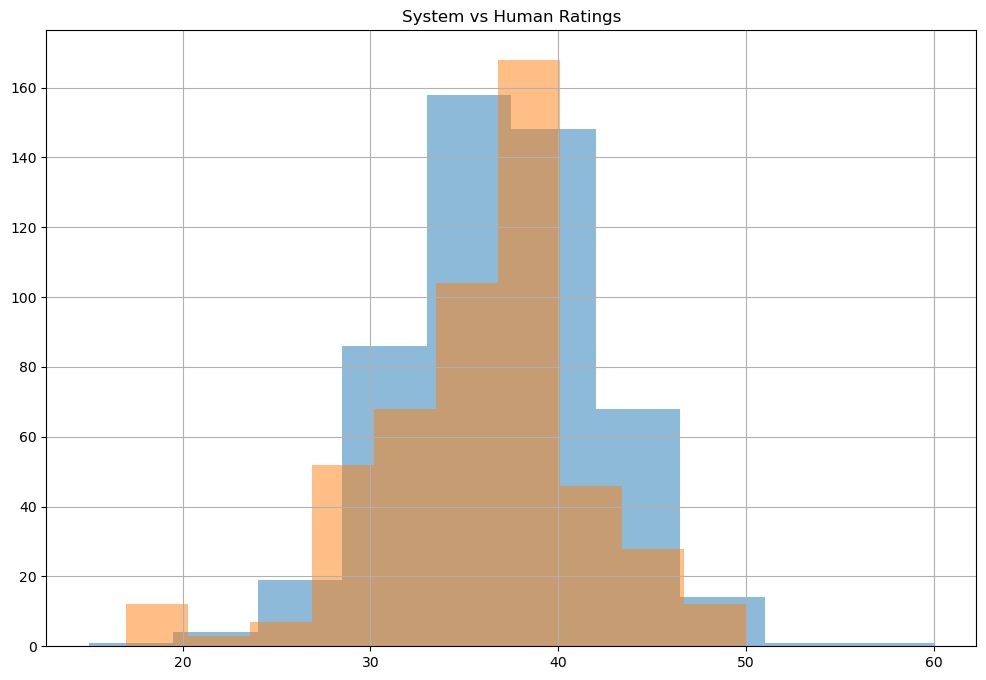

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))
comparison_df[["Resolved Score"]].hist(alpha=0.5, ax=ax)
comparison_df[["System Overall"]].hist(alpha=0.5, ax=ax)
ax.set_title("System vs Human Ratings")

In [167]:
submission_ids

[1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179]

In [168]:
comparison_df.to_excel('ratings_comparison_withrubric_andcritic_withknowledgebase1.xlsx')


In [169]:
pd.DataFrame.from_dict(correlations).to_excel('correlations_withrubric_andcritic_withknowledgebase1.xlsx')

In [170]:
comparison_df.describe().to_excel('summary_stats_withrubric_andcritic_withknowledgebase1.xlsx')

In [22]:
API_BASE_URL = "http://localhost:8000/api"

In [51]:
# Backend API URL
API_URL = "http://localhost:8000/api"

In [52]:
def fetch_submissions_with_cycles(assignment_id):
    response = requests.get(f"{API_BASE_URL}/submissions/with_knowledge_base_items/?assignment={assignment_id}")
    return response.json()

def normalize_score(score, min_score, max_score):
    return (score - min_score) / (max_score - min_score)


In [53]:
# Function to create a submission
def create_submission(essay):
    response = requests.post(f"{API_URL}/submissions/", json={
        "content": essay,
        "assignment": 22, 
        "student_name": "Anonymous"
    })
    return response.json()

In [54]:
# Function to get grading results
def get_grading_results(submission_id):
    response = requests.get(f"{API_URL}/submissions/{submission_id}/")
    return response.json()

In [55]:
# Function to get knowledge base items
def get_knowledge_base_items():
    response = requests.get(f"{API_URL}/knowledge-base/")
    return response.json()

In [56]:
assignment_id = 22  # Replace with the correct assignment ID
submissions_data = fetch_submissions_with_cycles(assignment_id)

# Process the data
processed_data = []
for submission in submissions_data:
    rater1_grade = submission.get('rater1_domain1')
    rater2_grade = submission.get('rater2_domain1')
    system_grade = submission.get('overall_score')
    
    if rater1_grade is not None:
        rater1_grade = normalize_score(rater1_grade, 0, 5)  # Assuming original scale is 0-5
    if rater2_grade is not None:
        rater2_grade = normalize_score(rater2_grade, 0, 5)  # Assuming original scale is 0-5
    
    processed_data.append({
        'Submission ID': submission['id'],
        'Rater1 Grade': rater1_grade,
        'Rater2 Grade': rater2_grade,
        'System Grade': system_grade
    })

comparison_df = pd.DataFrame(processed_data)

In [57]:
comparison_df

""


In [12]:

def calculate_correlations(df):
    correlations = {}
    for col1 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
        for col2 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
            if col1 != col2:
                mask = ~np.isnan(df[col1]) & ~np.isnan(df[col2])
                pearson, _ = stats.pearsonr(df[col1][mask], df[col2][mask])
                spearman, _ = stats.spearmanr(df[col1][mask], df[col2][mask])
                correlations[f"{col1} vs {col2}"] = {
                    'Pearson': pearson,
                    'Spearman': spearman
                }
    return correlations

assignment_id = 22  # Replace with the correct assignment ID

response = requests.get(f"{API_URL}/assignments/{assignment_id}/")
assignment = response.json()
rubric = assignment['rubric']

# Calculate min and max scores based on the rubric
min_score = 1
max_score = len(rubric['categories']) + 1

# Function to normalize scores to 0-1 range
def normalize_score(score, min_score, max_score):
    return (score - min_score) / (max_score - min_score)

# Normalize Rater1 and Rater2 grades
comparison_df['Rater1 Grade Normalized'] = comparison_df['Rater1 Grade'].apply(lambda x: normalize_score(x, min_score, max_score))
comparison_df['Rater2 Grade Normalized'] = comparison_df['Rater2 Grade'].apply(lambda x: normalize_score(x, min_score, max_score))


In [13]:
comparison_df.sort_values(by="Rater1 Grade Normalized", ascending=False )


,Submission ID,Rater1 Grade,Rater2 Grade,System Grade,Rater1 Grade Normalized,Rater2 Grade Normalized
1,101,5.0,4.0,0.333333,4.0,3.0
3,103,5.0,5.0,0.500000,4.0,4.0
0,100,4.0,4.0,0.500000,3.0,3.0
2,102,4.0,3.0,0.333333,3.0,2.0
4,104,4.0,4.0,0.333333,3.0,3.0


In [169]:
correlations = calculate_correlations(comparison_df)
print("Correlations:")
print(json.dumps(correlations, indent=2))

Correlations:
{
  "Rater1 Grade vs Rater2 Grade": {
    "Pearson": 0.6454972243679029,
    "Spearman": 0.6454972243679028
  },
  "Rater1 Grade vs System Grade": {
    "Pearson": -0.6344412685745155,
    "Spearman": -0.6454972243679028
  },
  "Rater2 Grade vs Rater1 Grade": {
    "Pearson": 0.6454972243679029,
    "Spearman": 0.6454972243679028
  },
  "Rater2 Grade vs System Grade": {
    "Pearson": 0.0,
    "Spearman": 0.0
  },
  "System Grade vs Rater1 Grade": {
    "Pearson": -0.6344412685745155,
    "Spearman": -0.6454972243679028
  },
  "System Grade vs Rater2 Grade": {
    "Pearson": 0.0,
    "Spearman": 0.0
  }
}


In [136]:
# Calculate and print mean absolute error
def calculate_mae(df):
    mae = {}
    for col1 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
        for col2 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
            if col1 != col2:
                mask = ~np.isnan(df[col1]) & ~np.isnan(df[col2])
                mae[f"{col1} vs {col2}"] = np.mean(np.abs(df[col1][mask] - df[col2][mask]))
    return mae

mae = calculate_mae(comparison_df)
print("\nMean Absolute Error:")
print(json.dumps(mae, indent=2))


Mean Absolute Error:
{
  "Rater1 Grade vs Rater2 Grade": 0.4,
  "Rater1 Grade vs System Grade": 4.106666666666667,
  "Rater2 Grade vs Rater1 Grade": 0.4,
  "Rater2 Grade vs System Grade": 3.9066666666666663,
  "System Grade vs Rater1 Grade": 4.106666666666667,
  "System Grade vs Rater2 Grade": 3.9066666666666663
}


In [10]:
import pandas as pd
import requests
import time
from tqdm import tqdm

# Load the dataset
df = pd.read_excel('data/asap-aes/training_set_rel3.xlsx')
API_BASE_URL = "http://localhost:8000/api"

# Assignment ID mapping
ASSIGNMENT_ID_MAP = {1: 13, 2: 25, 3: 18, 4: 20, 5: 23, 6: 22, 7: 24, 8: 12}

# Score ranges and adjustment methods for each essay set
SCORE_ADJUSTMENTS = {
    1: lambda score: score * 6,  
    2: lambda score: score * 6,  
    3: lambda score: (score * 3),       
    4: lambda score: (score * 3),       
    5: lambda score: (score * 4),       
    6: lambda score: (score * 4),      
    7: lambda score: (score * 15),      
    8: lambda score: (score * 30)      
}

def create_submission(essay, assignment_id):
    response = requests.post(f"{API_BASE_URL}/submissions/submit_text/", json={
        "content": essay,
        "assignment": assignment_id, 
        "student_name": "Anonymous"
    })
    if response.status_code != 201:
        print(f"Error creating submission: {response.status_code}")
        return None
    return response.json()

def get_grading_results(submission_id):
    try: 
        response = requests.get(f"{API_BASE_URL}/submissions/{submission_id}/")
        data = response.json()
        
        if data.get('status') == 'graded':
            return {
                'status': 'graded',
                'overall_score': data.get('overall_score'),
                'category_scores': data.get('category_scores', [])
            }
        
        return {
            'status': 'pending',
            'overall_score': None,
            'category_scores': None
        }
    except Exception as e: 
        pass 

def adjust_score(score, essay_set):
    return SCORE_ADJUSTMENTS[essay_set](score)

def get_human_score(row, essay_set):
    if essay_set == 1: 
        return (row['rater1_domain1'] + row['rater2_domain1']) / 2
    if essay_set == 2:
        # For essay set 2, use the resolved score for domain 1
        return row['domain1_score']
    elif essay_set == 7:
        # For essay set 7, sum the scores from rater 1 and rater 2
        return (row['rater1_domain1'] + row['rater2_domain1']) / 2
    elif essay_set == 8:
        # For essay set 8, use the resolved score
        return row['domain1_score'] / 2
    else:
        # For other essay sets, use the resolved score
        return row['domain1_score']

def process_submissions(df_sample, assignment_id, essay_set):
    results = []
    
    for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
        submission = create_submission(row['essay'], assignment_id)
        if submission is None:
            continue
        
        submission_id = submission.get('id')
        if not submission_id:
            print(f"Unable to find submission ID in response: {submission}")
            continue
        
        max_attempts = 20
        attempt = 0
        while attempt < max_attempts:
            result = get_grading_results(submission_id)
            if result['status'] == 'graded':
                adjusted_score = adjust_score(result['overall_score'], essay_set)
                human_score = get_human_score(row, essay_set)
                results.append({
                    'essay_id': row['essay_id'],
                    'essay_set': essay_set,
                    'human_score': human_score,
                    'system_score': adjusted_score,
                    'raw_system_score': result['overall_score'],
                    'category_scores': result['category_scores']
                })
                break
            time.sleep(10)
            attempt += 1
        
        if attempt == max_attempts:
            print(f"Grading not completed for submission {submission_id} after {max_attempts} attempts")
    
    return results

def main(n_submissions_per_set):
    all_results = []
    
    for essay_set in range(1, 2):
        print(f"\nProcessing Essay Set {essay_set}")
        df_sample = df[df["essay_set"] == essay_set].sample(n=n_submissions_per_set, random_state=42)
        assignment_id = ASSIGNMENT_ID_MAP[essay_set]
        results = process_submissions(df_sample, assignment_id, essay_set)
        all_results.extend(results)
    
    # Create DataFrame from results
    results_df = pd.DataFrame(all_results)
    
    # Explode category scores into separate columns
    if 'category_scores' in results_df.columns:
        category_scores = pd.DataFrame(results_df['category_scores'].tolist())
        results_df = pd.concat([results_df.drop('category_scores', axis=1), category_scores], axis=1)
    
    # Save results to CSV
    results_df.to_csv('regai_scoring_results.csv', index=False)
    print("\nResults saved to 'regai_scoring_results.csv'")
    
    return results_df

# Run the script
n_submissions_per_set = 5  # Adjust this number as needed
results_table = main(n_submissions_per_set)

# Display the first few rows of the results
print(results_table.head())


Processing Essay Set 1


100%|██████████| 5/5 [01:37<00:00, 19.50s/it]


Results saved to 'regai_scoring_results.csv'
   essay_id  essay_set  human_score  system_score  raw_system_score  \
0       827          1          6.0           6.0          0.500000   
1      1477          1          6.0           4.0          0.333333   
2       234          1          8.0           8.0          0.666667   
3       801          1          9.0           4.0          0.333333   
4       780          1          9.0           6.0          0.500000   

                                                   0  
0  {'name': 'Overall Quality', 'score': 3, 'justi...  
1  {'name': 'Overall Quality', 'score': 2, 'justi...  
2  {'name': 'Overall Quality', 'score': 4, 'justi...  
3  {'name': 'Overall Quality', 'score': 2, 'justi...  
4  {'name': 'Overall Quality', 'score': 3, 'justi...  


In [23]:
results_table

,essay_id,essay_set,human_score,system_score,raw_system_score,0,1,2,3,4,5
0,21135,8,40.0,46.0,0.766667,"{'name': 'Ideas and Content', 'score': 5, 'jus...","{'name': 'Organization', 'score': 5, 'justific...","{'name': 'Voice', 'score': 5, 'justification':...","{'name': 'Word Choice', 'score': 4, 'justifica...","{'name': 'Sentence Fluency', 'score': 5, 'just...","{'name': 'Conventions', 'score': 4, 'justifica..."
1,21364,8,45.0,48.0,0.800000,"{'name': 'Ideas and Content', 'score': 5, 'jus...","{'name': 'Organization', 'score': 5, 'justific...","{'name': 'Voice', 'score': 5, 'justification':...","{'name': 'Word Choice', 'score': 4, 'justifica...","{'name': 'Sentence Fluency', 'score': 4, 'just...","{'name': 'Conventions', 'score': 5, 'justifica..."
2,21468,8,35.0,48.0,0.800000,"{'name': 'Ideas and Content', 'score': 5, 'jus...","{'name': 'Organization', 'score': 5, 'justific...","{'name': 'Voice', 'score': 5, 'justification':...","{'name': 'Word Choice', 'score': 4, 'justifica...","{'name': 'Sentence Fluency', 'score': 4, 'just...","{'name': 'Conventions', 'score': 5, 'justifica..."
3,20760,8,30.0,44.0,0.733333,"{'name': 'Ideas and Content', 'score': 5, 'jus...","{'name': 'Organization', 'score': 4, 'justific...","{'name': 'Voice', 'score': 5, 'justification':...","{'name': 'Word Choice', 'score': 5, 'justifica...","{'name': 'Sentence Fluency', 'score': 4, 'just...","{'name': 'Conventions', 'score': 4, 'justifica..."
4,21263,8,32.0,27.0,0.450000,"{'name': 'Ideas and Content', 'score': 4, 'jus...","{'name': 'Organization', 'score': 3, 'justific...","{'name': 'Voice', 'score': 4, 'justification':...","{'name': 'Word Choice', 'score': 3, 'justifica...","{'name': 'Sentence Fluency', 'score': 3, 'just...","{'name': 'Conventions', 'score': 1, 'justifica..."
5,21257,8,30.0,39.0,0.650000,"{'name': 'Ideas and Content', 'score': 5, 'jus...","{'name': 'Organization', 'score': 5, 'justific...","{'name': 'Voice', 'score': 5, 'justification':...","{'name': 'Word Choice', 'score': 4, 'justifica...","{'name': 'Sentence Fluency', 'score': 4, 'just...","{'name': 'Conventions', 'score': 2, 'justifica..."
6,20797,8,33.0,48.0,0.800000,"{'name': 'Ideas and Content', 'score': 6, 'jus...","{'name': 'Organization', 'score': 5, 'justific...","{'name': 'Voice', 'score': 5, 'justification':...","{'name': 'Word Choice', 'score': 5, 'justifica...","{'name': 'Sentence Fluency', 'score': 4, 'just...","{'name': 'Conventions', 'score': 4, 'justifica..."
7,20852,8,40.0,45.0,0.750000,"{'name': 'Ideas and Content', 'score': 5, 'jus...","{'name': 'Organization', 'score': 5, 'justific...","{'name': 'Voice', 'score': 5, 'justification':...","{'name': 'Word Choice', 'score': 4, 'justifica...","{'name': 'Sentence Fluency', 'score': 4, 'just...","{'name': 'Conventions', 'score': 4, 'justifica..."
8,21033,8,27.0,47.0,0.783333,"{'name': 'Ideas and Content', 'score': 6, 'jus...","{'name': 'Organization', 'score': 5, 'justific...","{'name': 'Voice', 'score': 5, 'justification':...","{'name': 'Word Choice', 'score': 4, 'justifica...","{'name': 'Sentence Fluency', 'score': 4, 'just...","{'name': 'Conventions', 'score': 4, 'justifica..."
9,21323,8,43.0,46.0,0.766667,"{'name': 'Ideas and Content', 'score': 5, 'jus...","{'name': 'Organization', 'score': 5, 'justific...","{'name': 'Voice', 'score': 5, 'justification':...","{'name': 'Word Choice', 'score': 5, 'justifica...","{'name': 'Sentence Fluency', 'score': 4, 'just...","{'name': 'Conventions', 'score': 4, 'justifica..."


In [7]:
import requests
import pandas as pd
from tabulate import tabulate

API_BASE_URL = "http://localhost:8000/api"

def fetch_all_submissions():
    """Fetch all submissions."""
    url = f"{API_BASE_URL}/submissions/"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching submissions: {response.status_code}")
        return None

def display_structure(obj, indent=0):
    """Recursively display the structure of an object."""
    for key, value in obj.items():
        print("  " * indent + f"{key}: ", end="")
        if isinstance(value, dict):
            print()
            display_structure(value, indent + 1)
        elif isinstance(value, list):
            if len(value) > 0:
                print(f"List of {len(value)} {type(value[0]).__name__}(s)")
                if isinstance(value[0], dict):
                    display_structure(value[0], indent + 1)
            else:
                print("Empty list")
        else:
            print(f"{type(value).__name__}")

def main():
    submissions_data = fetch_all_submissions()
    
    if submissions_data and 'results' in submissions_data:
        submissions = submissions_data['results']
        if len(submissions) > 0:
            print("\n--- Overall Submission Structure ---")
            display_structure(submissions[0])
            
            # Create a summary table
            summary_data = []
            for sub in submissions:
                row = {
                    'ID': sub.get('id'),
                    'Assignment': sub.get('assignment'),
                    'Student': sub.get('student_name'),
                    'Status': sub.get('status'),
                    'Overall Score': sub.get('overall_score'),
                    'Submitted At': sub.get('submitted_at')
                }
                summary_data.append(row)
            
            # Display summary table
            df = pd.DataFrame(summary_data)
            print("\nSubmissions Summary:")
            print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))
            
            print(f"\nTotal number of submissions: {len(submissions)}")
            print(f"Number of pages: {submissions_data.get('count', 'Unknown')}")
            print(f"Next page: {submissions_data.get('next', 'None')}")
            print(f"Previous page: {submissions_data.get('previous', 'None')}")
        else:
            print("No submissions found in the results.")
    else:
        print("No submissions data found or unexpected data structure.")

if __name__ == "__main__":
    main()


--- Overall Submission Structure ---
id: int
assignment: int
student_name: str
content: str
file: NoneType
submitted_at: str
status: str
overall_score: float
category_scores: List of 1 dict(s)
  name: str
  score: int
  justification: str
grading_critique: 
  overall_assessment: str
  category_critiques: List of 1 dict(s)
    category: str
    critique: str
  potential_biases: Empty list
  suggestions_for_improvement: List of 2 str(s)
  revision_status: str
graded_at: str
grades: Empty list

Submissions Summary:
+------+--------------+-----------+----------+-----------------+-----------------------------+
|   ID |   Assignment | Student   | Status   |   Overall Score | Submitted At                |
|------+--------------+-----------+----------+-----------------+-----------------------------|
| 2408 |           18 | Anonymous | graded   |        0.25     | 2024-08-01T14:14:05.870543Z |
| 2407 |           17 | Anonymous | graded   |        0.333333 | 2024-08-01T14:12:35.901809Z |
| 2406

In [7]:
import requests
import json
from IPython.display import display, HTML

# Set your API base URL here
API_BASE_URL = "http://localhost:8000/api"  # Adjust this if your API is hosted elsewhere

def fetch_submissions_with_knowledge_base(assignment_id):
    url = f"{API_BASE_URL}/submissions/with_knowledge_base_items/?assignment={assignment_id}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None

def analyze_submission_data(data):
    if not data:
        print("No data received from the API.")
        return

    print(f"Total submissions: {len(data)}")
    
    for idx, submission in enumerate(data, 1):
        print(f"\nSubmission {idx}:")
        print(f"Student Name: {submission.get('student_name', 'N/A')}")
        print(f"Status: {submission.get('status', 'N/A')}")
        print(f"Overall Score: {submission.get('overall_score', 'N/A')}")
        
        kb_items = submission.get('knowledge_base_items', {})
        
        grades = kb_items.get('grades', [])
        critiques = kb_items.get('critiques', [])
        final_grade = kb_items.get('final_grade')
        
        print(f"Number of grades: {len(grades)}")
        print(f"Number of critiques: {len(critiques)}")
        print(f"Final grade exists: {'Yes' if final_grade else 'No'}")
        
        if not grades and not final_grade:
            print("WARNING: No grades found for this submission")
        
        # Display the first grade and critique if they exist
        if grades:
            print("\nFirst Grade:")
            display(HTML(f"<pre>{json.dumps(grades[0], indent=2)}</pre>"))
        
        if critiques:
            print("\nFirst Critique:")
            display(HTML(f"<pre>{json.dumps(critiques[0], indent=2)}</pre>"))
        
        if final_grade:
            print("\nFinal Grade:")
            display(HTML(f"<pre>{json.dumps(final_grade, indent=2)}</pre>"))
        
        print("-" * 50)

# Use the functions
assignment_id = 13  # Replace with the assignment ID you want to analyze
data = fetch_submissions_with_knowledge_base(assignment_id)
analyze_submission_data(data)

Total submissions: 4

Submission 1:
Student Name: Anonymous
Status: graded
Overall Score: 0.33333333333333326
Number of grades: 4
Number of critiques: 3
Final grade exists: Yes

First Grade:



First Critique:



Final Grade:


--------------------------------------------------

Submission 2:
Student Name: Anonymous
Status: graded
Overall Score: 0.5
Number of grades: 4
Number of critiques: 3
Final grade exists: Yes

First Grade:



First Critique:



Final Grade:


--------------------------------------------------

Submission 3:
Student Name: Anonymous
Status: graded
Overall Score: 0.16666666666666663
Number of grades: 4
Number of critiques: 3
Final grade exists: Yes

First Grade:



First Critique:



Final Grade:


--------------------------------------------------

Submission 4:
Student Name: Anonymous
Status: graded
Overall Score: 0.33333333333333326
Number of grades: 4
Number of critiques: 3
Final grade exists: Yes

First Grade:



First Critique:



Final Grade:


--------------------------------------------------


In [59]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font, Alignment, Border, Side
from openpyxl.drawing.image import Image
import requests
import time
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, cohen_kappa_score


# Load the dataset
df = pd.read_excel('data/asap-aes/training_set_rel3.xlsx')
API_BASE_URL = "http://localhost:8000/api"

# Assignment ID mapping
ASSIGNMENT_ID_MAP = {1: 13}

# Score range and adjustment method for essay set 1
SCORE_ADJUSTMENT = lambda score: score * 6

def save_to_excel(df, sheet_name, workbook):
    ws = workbook.create_sheet(sheet_name)
    
    for r in dataframe_to_rows(df, index=False, header=True):
        ws.append(r)
    
    # Format header
    for cell in ws[1]:
        cell.font = Font(bold=True)
        cell.alignment = Alignment(horizontal='center', vertical='center')
        cell.border = Border(bottom=Side(style='thin'))
    
    # Auto-adjust column widths
    for column in ws.columns:
        max_length = 0
        column_letter = column[0].column_letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(cell.value)
            except:
                pass
        adjusted_width = (max_length + 2)
        ws.column_dimensions[column_letter].width = adjusted_width

def bulk_submit(essays, assignment_id):
    submissions_data = [
        {
            "content": essay,
            "student_name": "Anonymous"
        }
        for essay in essays
    ]
    
    response = requests.post(f"{API_BASE_URL}/submissions/bulk_submit/", json={
        "assignment": assignment_id,
        "submissions": submissions_data
    })
    
    if response.status_code != 201:
        print(f"Error in bulk submission: {response.status_code}")
        return None
    return response.json()

def get_bulk_grading_results(submission_ids):
    results = []
    for submission_id in submission_ids:
        try:
            response = requests.get(f"{API_BASE_URL}/submissions/{submission_id}/")
            data = response.json()
            
            if data.get('status') == 'graded':
                results.append({
                    'id': submission_id,
                    'status': 'graded',
                    'overall_score': data.get('overall_score'),
                    'category_scores': data.get('category_scores', [])
                })
            else:
                results.append({
                    'id': submission_id,
                    'status': 'pending',
                    'overall_score': None,
                    'category_scores': None
                })
        except Exception as e:
            print(f"Error getting grading results for submission {submission_id}: {e}")
            results.append({
                'id': submission_id,
                'status': 'error',
                'overall_score': None,
                'category_scores': None
            })
    
    return results

def get_human_score(row):
    return (row['rater1_domain1'] + row['rater2_domain1']) / 2

def quadratic_weighted_kappa(rater_a, rater_b, min_rating=0, max_rating=6):
    assert(len(rater_a) == len(rater_b))
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    
    hist1 = np.histogram(rater_a, bins=max_rating+1, range=(min_rating, max_rating))[0]
    hist2 = np.histogram(rater_b, bins=max_rating+1, range=(min_rating, max_rating))[0]
    
    numerator = 0.0
    denominator = 0.0
    
    confusion_matrix = np.histogram2d(rater_a, rater_b, bins=max_rating+1, range=[[min_rating, max_rating], [min_rating, max_rating]])[0]
    
    for i in range(len(hist1)):
        for j in range(len(hist2)):
            expected_count = hist1[i] * hist2[j] / len(rater_a)
            d = pow(i - j, 2.0) / pow(max_rating - min_rating, 2.0)
            numerator += d * confusion_matrix[i][j] / len(rater_a)
            denominator += d * expected_count / len(rater_a)
    
    return 1.0 - numerator / denominator

def calculate_metrics(human_scores, system_scores):
    correlation = stats.pearsonr(human_scores, system_scores)[0]
    mae = mean_absolute_error(human_scores, system_scores)
    qwk = quadratic_weighted_kappa(human_scores, system_scores)
    return correlation, mae, qwk

def get_human_score(row):
    return {
        'rater1_domain1': row['rater1_domain1'],
        'rater2_domain1': row['rater2_domain1'],
        'domain1_score': row['domain1_score']
    }

def process_submissions(df_sample, assignment_id, essay_id, num_submissions):
    essays = df_sample['essay'].tolist()
    
    print("Submitting essays in bulk...")
    bulk_response = bulk_submit(essays, assignment_id)
    if bulk_response is None:
        return []
    
    submission_ids = [sub['id'] for sub in bulk_response['submissions']]
    
    print("Waiting for grading to complete...")
    max_attempts = 20
    with tqdm(total=num_submissions, desc="Grading Progress") as pbar:
        for attempt in range(max_attempts):
            grading_results = get_bulk_grading_results(submission_ids)
            graded_count = sum(1 for result in grading_results if result['status'] == 'graded')
            pbar.update(graded_count - pbar.n)  # Update progress bar
            
            if graded_count == num_submissions:
                break
            
            if attempt < max_attempts - 1:  # Don't sleep on the last attempt
                time.sleep(10)
    
    if graded_count < num_submissions:
        print(f"Grading not completed for all submissions after {max_attempts} attempts")
    
    results = []
    for idx, (_, row) in enumerate(df_sample.iterrows()):
        result = grading_results[idx]
        if result['status'] == 'graded':
            raw_system_score = result['overall_score']
            adjusted_system_score = SCORE_ADJUSTMENT(raw_system_score)
            human_scores = get_human_score(row)
            
            # Flatten category scores
            category_scores = result['category_scores'][0] if result['category_scores'] else {}
            result_dict = {
                'essay_id': row['essay_id'],
                'raw_rater1_score': human_scores['rater1_domain1'],
                'raw_rater2_score': human_scores['rater2_domain1'],
                'raw_resolved_score': human_scores['domain1_score'],
                'adjusted_human_score': (human_scores['rater1_domain1'] + human_scores['rater2_domain1']) / 2,
                'raw_system_score': raw_system_score,
                'adjusted_system_score': adjusted_system_score
            }
            result_dict.update({f"category_{k}": v for k, v in category_scores.items() if k != 'justification'})
            result_dict['justification'] = category_scores.get('justification', '')
            
            results.append(result_dict)
    
    return results

    
def create_visualizations(results_df, wb):
    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(results_df['adjusted_human_score'], results_df['adjusted_system_score'])
    plt.xlabel('Human Score (Adjusted)')
    plt.ylabel('System Score (Adjusted)')
    plt.title('Human vs System Scores')
    plt.savefig('scatter_plot.png')
    plt.close()
    
    # Add image to Excel
    img = Image('scatter_plot.png')
    ws = wb.create_sheet("Visualizations")
    ws.add_image(img, 'A1')

    # Histogram
    plt.figure(figsize=(10, 6))
    plt.hist(results_df['adjusted_human_score'], alpha=0.5, label='Human Scores')
    plt.hist(results_df['adjusted_system_score'], alpha=0.5, label='System Scores')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Human and System Scores')
    plt.legend()
    plt.savefig('histogram.png')
    plt.close()
    
    # Add image to Excel
    img = Image('histogram.png')
    ws.add_image(img, 'A20')

    # Heatmap of score differences
    score_diff = results_df['adjusted_system_score'] - results_df['adjusted_human_score']
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.crosstab(results_df['adjusted_human_score'], score_diff), cmap='YlOrRd')
    plt.xlabel('Score Difference (System - Human)')
    plt.ylabel('Human Score')
    plt.title('Heatmap of Score Differences')
    plt.savefig('heatmap.png')
    plt.close()
    
    # Add image to Excel
    img = Image('heatmap.png')
    ws.add_image(img, 'A40')

def calculate_metrics(human_scores, system_scores):
    correlation = stats.pearsonr(human_scores, system_scores)[0]
    mae = mean_absolute_error(human_scores, system_scores)
    qwk = quadratic_weighted_kappa(human_scores, system_scores)
    return correlation, mae, qwk

def main(essay_id=None, num_submissions_to_eval=100):
    wb = Workbook()
    wb.remove(wb.active)  # Remove the default sheet

    df_sample = df[df["essay_set"] == 1].sample(n=num_submissions_to_eval, random_state=42)
    assignment_id = ASSIGNMENT_ID_MAP[1]
    results = process_submissions(df_sample, assignment_id, essay_id, num_submissions_to_eval)
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Check if the DataFrame is empty
    if results_df.empty:
        print("No results were obtained. Please check your API and submission process.")
        return None, None
    
    # Calculate metrics using adjusted scores
    correlation, mae, qwk = calculate_metrics(results_df['adjusted_human_score'], results_df['adjusted_system_score'])
    
    # Create summary DataFrame
    summary_df = pd.DataFrame({
        'Metric': ['Correlation', 'MAE', 'QWK'],
        'Value': [correlation, mae, qwk]
    })
    
    # Save results and summary to Excel
    save_to_excel(results_df, "Grading Results", wb)
    save_to_excel(summary_df, "Summary Metrics", wb)
    
    # Create and save visualizations
    create_visualizations(results_df, wb)
    
    # Save Excel workbook
    wb.save(f'essay_set_{essay_id}_grading_analysis2.xlsx')
    print(f"\nResults saved to 'essay_set_{essay_id}_grading_analysis2.xlsx'")
    
    return results_df, summary_df

# Run the script
essay_id = 1  # Set to None to evaluate all essays, or specify an essay_id to evaluate a single essay
num_submissions_to_eval = 50  # Adjust this number as needed
results_df, summary_df = main(essay_id, num_submissions_to_eval)

# Display summary metrics
if summary_df is not None:
    print("\nSummary Metrics:")
    print(summary_df)
else:
    print("\nNo summary metrics available due to an error in processing.")

Submitting essays in bulk...
Waiting for grading to complete...


Grading Progress: 100%|██████████| 50/50 [01:43<00:00,  2.06s/it]



Results saved to 'essay_set_1_grading_analysis2.xlsx'

Summary Metrics:
        Metric     Value
0  Correlation  0.090727
1          MAE  1.060000
2          QWK  0.086758


In [60]:
results_df

,essay_id,raw_rater1_score,raw_rater2_score,raw_resolved_score,adjusted_human_score,raw_system_score,adjusted_system_score,category_name,category_score,justification
0,827,3.0,3.0,6.0,3.0,0.333333,2.0,Overall Quality,2,The essay is under-developed with a weak and u...
1,1477,3.0,3.0,6.0,3.0,0.500000,3.0,Overall Quality,3,The essay takes a position regarding the effec...
2,234,4.0,4.0,8.0,4.0,0.666667,4.0,Overall Quality,4,The essay takes a clear position that computer...
3,801,4.0,5.0,9.0,4.5,0.333333,2.0,Overall Quality,2,The essay presents a weak position with numero...
4,780,5.0,4.0,9.0,4.5,0.666667,4.0,Overall Quality,4,The essay clearly establishes a position again...
5,271,4.0,4.0,8.0,4.0,0.666667,4.0,Overall Quality,4,The essay takes a clear position that computer...
6,419,3.0,3.0,6.0,3.0,0.666667,4.0,Overall Quality,4,The essay presents a clear position that compu...
7,1441,4.0,4.0,8.0,4.0,0.500000,3.0,Overall Quality,3,The essay takes a position against the benefic...
8,1391,4.0,4.0,8.0,4.0,0.500000,3.0,Overall Quality,3,The essay takes a position by asserting that c...
9,112,5.0,4.0,9.0,4.5,0.666667,4.0,Overall Quality,4,The essay presents a clear position against th...


In [40]:
stats.pearsonr(results_df['adjusted_human_score'], results_df['adjusted_system_score'])

PearsonRResult(statistic=0.05912098810029066, pvalue=0.5610488235616752)

<Axes: >

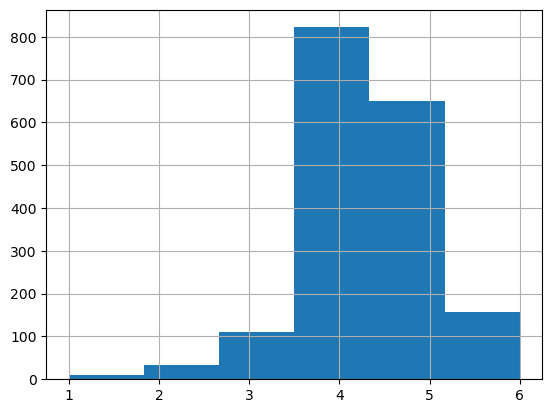

In [28]:
((df[df['essay_set'] == 1]['rater1_domain1'] + df[df['essay_set'] == 1]['rater2_domain1']) / 2).hist(bins=6)

<Axes: >

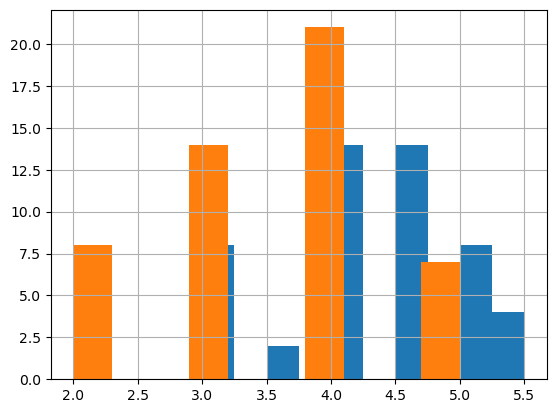

In [61]:
results_df['adjusted_human_score'].hist(bins=10)
results_df['adjusted_system_score'].hist(bins=10)